# Dutch Corpora

Before running this notebook, install the `tempo-embeddings` package in your local environment:

```bash
pip install .
```

See [README.dev.md](../README.dev.md) for more details.

In [75]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Model

In [76]:
%autoreload now

LAYER=12

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
)

kwargs = {"accelerate": True}

# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

MODEL_NAME = "facebook/xmod-base"
kwargs["default_language"] = "nl_XX"
model_class = XModModelWrapper


# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

In [77]:
model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)

Some weights of XmodModel were not initialized from the model checkpoint at facebook/xmod-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

In [78]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 0
RANDOM_SAMPLE_STATEN_GENERAAL = 100

### ANP

In [79]:
from pathlib import Path


DATA_DIR = Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris"
assert DATA_DIR.is_dir()

In [80]:
ANP_DIR = DATA_DIR / "ANP" / "CleanFiles_perYear"
assert ANP_DIR.is_dir()


In [81]:
import random

random.seed(0)

files = random.sample(list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP)
files[:10]

[]

In [82]:
%autoreload now

import operator
from functools import reduce
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus


anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                model=model,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(files, unit="file")
        ),
    )
    if files
    else Corpus(model=model)
)

len(anp_corpus)

0

### Staten Generaal

In [83]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert STATEN_GENERAAL_DIR.is_dir()

In [144]:
files = random.sample(
    list(STATEN_GENERAAL_DIR.glob("StatenGeneraal_????.csv.gz")),
    k=RANDOM_SAMPLE_STATEN_GENERAAL,
)
# files = list(STATEN_GENERAAL_DIR.glob("StatenGeneraal_2???.csv.gz"))
files[:10]

[PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1881.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1926.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1884.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1819.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1858.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1943.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1918.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal

In [145]:
import csv

csv.field_size_limit(100000000)

sg_corpus = reduce(
    operator.add,
    (
        Corpus.from_csv_file(
            path,
            model=model,
            text_columns=["Content"],
            encoding="utf-8",
            compression="gzip",
            delimiter=";",
            window_size=WINDOW_SIZE,
        )
        for path in tqdm(files, unit="file")
    )
    if files
    else Corpus(model=model),
)

len(sg_corpus)

100%|██████████| 100/100 [01:02<00:00,  1.59file/s]


14699229

In [146]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

206 Passage('Vel 30. 135 Eerste Kamer.13de ZITTING. — 10 JANUARIJ. Mededeeling van ingekomen stukken. 13* ZITTING . AYOXDZITTIXG VAX MAANDAG 10 JAXUAMJ. (OKOPKNP TKN 8 URK.) Ingekomen: 1°. berigfen van leden, verhinderd', {'': '0', 'date': '1881-01-10', 'title': 'Handelingen Eerste Kamer 1880-1881 10 januari 1881, Paginas 135-136.', 'RecId': 'nl.proc.sgd.d.188018810000086', 'type': 'Verbatim Proceedings', 'leg_period': '1880-1881', 'chamber': 'EersteKamer', 'speakers': 'nl.m.00393: chair, voorzitter: van Eysinga; nl.m.01158: mp, De heer: van Rijckevorsel', 'year': '1881'}, None)
208 Passage('verhinderd de zitting bij te wonen ; 2°. Regeringsbescheiden. — Trekking der afdeelingen. — Verlof verleend arm den lieer van Rijckevorsel , tot het rigten eener interpellatie aan den Minister van Waterstaat,', {'': '0', 'date': '1881-01-10', 'title': 'Handelingen Eerste Kamer 1880-1881 10 januari 1881, Paginas 135-136.', 'RecId': 'nl.proc.sgd.d.188018810000086', 'type': 'Verbatim Proceedings', 'le

### Merge

In [147]:
corpus = anp_corpus + sg_corpus
len(corpus)

14699229

## Compute Embeddings

In [148]:
TERM = "duurzaam"

In [149]:
%autoreload now

subcorpus = corpus.subcorpus(TERM, exact_match=False)
len(subcorpus)

12811

In [158]:
from tempo_embeddings.embeddings.model import EmbeddingsMethod

model.batch_size = 64
model.embeddings_method = EmbeddingsMethod.TOKEN
model.layer = 12

subcorpus.compute_embeddings()

Embeddings: 100%|██████████| 201/201 [01:15<00:00,  2.65batch/s]


## Read Stopwords

In [159]:
stopwords_file = (
    Path().absolute().parent / "tempo_embeddings" / "data" / "stopwords-filter-nl.txt"
)

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())
stopwords.update({"wij", "we", "moeten"})

In [160]:
#vectorizer = corpus.tfidf_vectorizer(stop_words=list(stopwords))

## Cluster

In [161]:
%autoreload now

from tempo_embeddings.text.cluster import Cluster

cluster = Cluster(subcorpus, vectorizer=None, n_topic_words=2)


In [162]:
cluster.cluster(stopwords=stopwords, min_cluster_size=10, cluster_selection_epsilon=0.2)

['wel; gescheiden',
 'duurzaamheid; heer',
 'wel; minister',
 'gescheiden; minister',
 'verduurzaamd; verduurzaamde',
 'veilig; bouwen',
 'duurzaamheid; minister',
 'Outliers',
 'onduurzaam; onduurzaamheid',
 'duurzaamheid; minister',
 'begrip; "duurzaam"',
 '"duurzaam; veilig"',
 'duurzaamheid; ecologische',
 '(duurzaam; milieubeheer']

# Visualize Embeddings

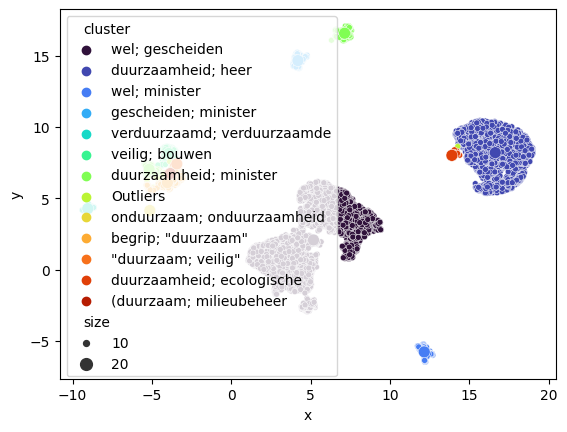

In [163]:
cluster.scatter_plot()

In [164]:
cluster.visualize()

### Refine sub-corpora

In [165]:
cluster.cluster_subcorpus("herstel_bezit", min_samples=8)

ValueError: Found 0 subcorpora with label 'herstel_bezit'.

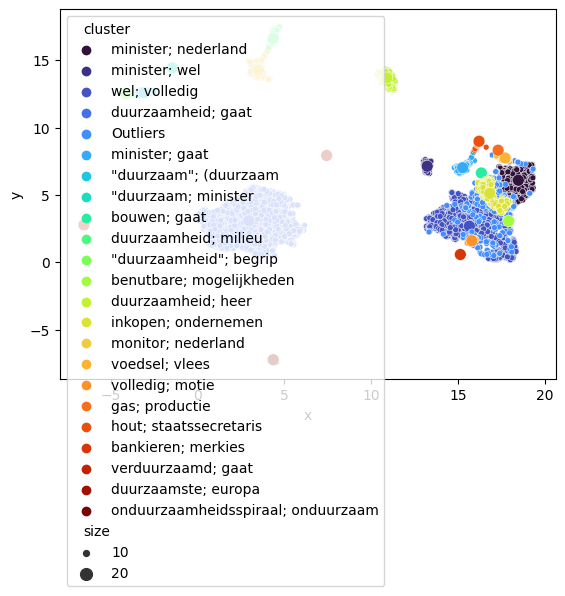

In [ ]:
cluster.scatter_plot()

In [ ]:
cluster.visualize()

In [ ]:
#cluster.merge("kunsthart_schipvoer", "bogers_dsm")


## Wizmap

In [ ]:
from tempo_embeddings.visualization.wizmap import WizmapVisualizer

port = 8000

if "wizmap_visualizer" in locals():
    # Cleanup previous run
    wizmap_visualizer.cleanup()


wizmap_visualizer = WizmapVisualizer(subcorpus, title=TERM, stopwords=stopwords)

wizmap_visualizer.visualize(port=port)

AttributeError: 'set' object has no attribute 'extend'

In [ ]:
if True:
    wizmap_visualizer.cleanup()